In [1]:
from __future__ import print_function
from sklearn.preprocessing import LabelEncoder  
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping    

def getAccScore(truth, predicted):
    return accuracy_score(truth, predicted), recall_score(truth, predicted), precision_score(truth, predicted)

data = pd.read_csv('kddcup.data_10_percent_corrected')

Using TensorFlow backend.


In [2]:
data.shape

(494021, 42)

In [3]:
data.dtypes

duration                         int64
protocol_type                   object
service                         object
flag                            object
src_bytes                        int64
dst_bytes                        int64
land                             int64
wrong_fragment                   int64
urgent                           int64
hot                              int64
num_failed_logins                int64
logged_in                        int64
num_compromised                  int64
root_shell                       int64
su_attempted                     int64
num_root                         int64
num_file_creations               int64
num_shells                       int64
num_access_files                 int64
num_outbound_cmds                int64
is_host_login                    int64
is_guest_login                   int64
count                            int64
srv_count                        int64
serror_rate                    float64
srv_serror_rate          

In [4]:
obj_df = data.select_dtypes(include=['object']).copy()

In [5]:
lb_make = LabelEncoder()
data["service"] = lb_make.fit_transform(data["service"])
data["protocol_type"] = lb_make.fit_transform(data["protocol_type"])
data["flag"] = lb_make.fit_transform(data["flag"])

In [6]:
data["flag"].head()

0    9
1    9
2    9
3    9
4    9
Name: flag, dtype: int32

In [7]:
pd.set_option('display.max_columns', 50)

In [8]:
X = data.iloc[:,:41]
y = data.iloc[:,41:]

y = pd.get_dummies(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [9]:
X.shape

(494021, 41)

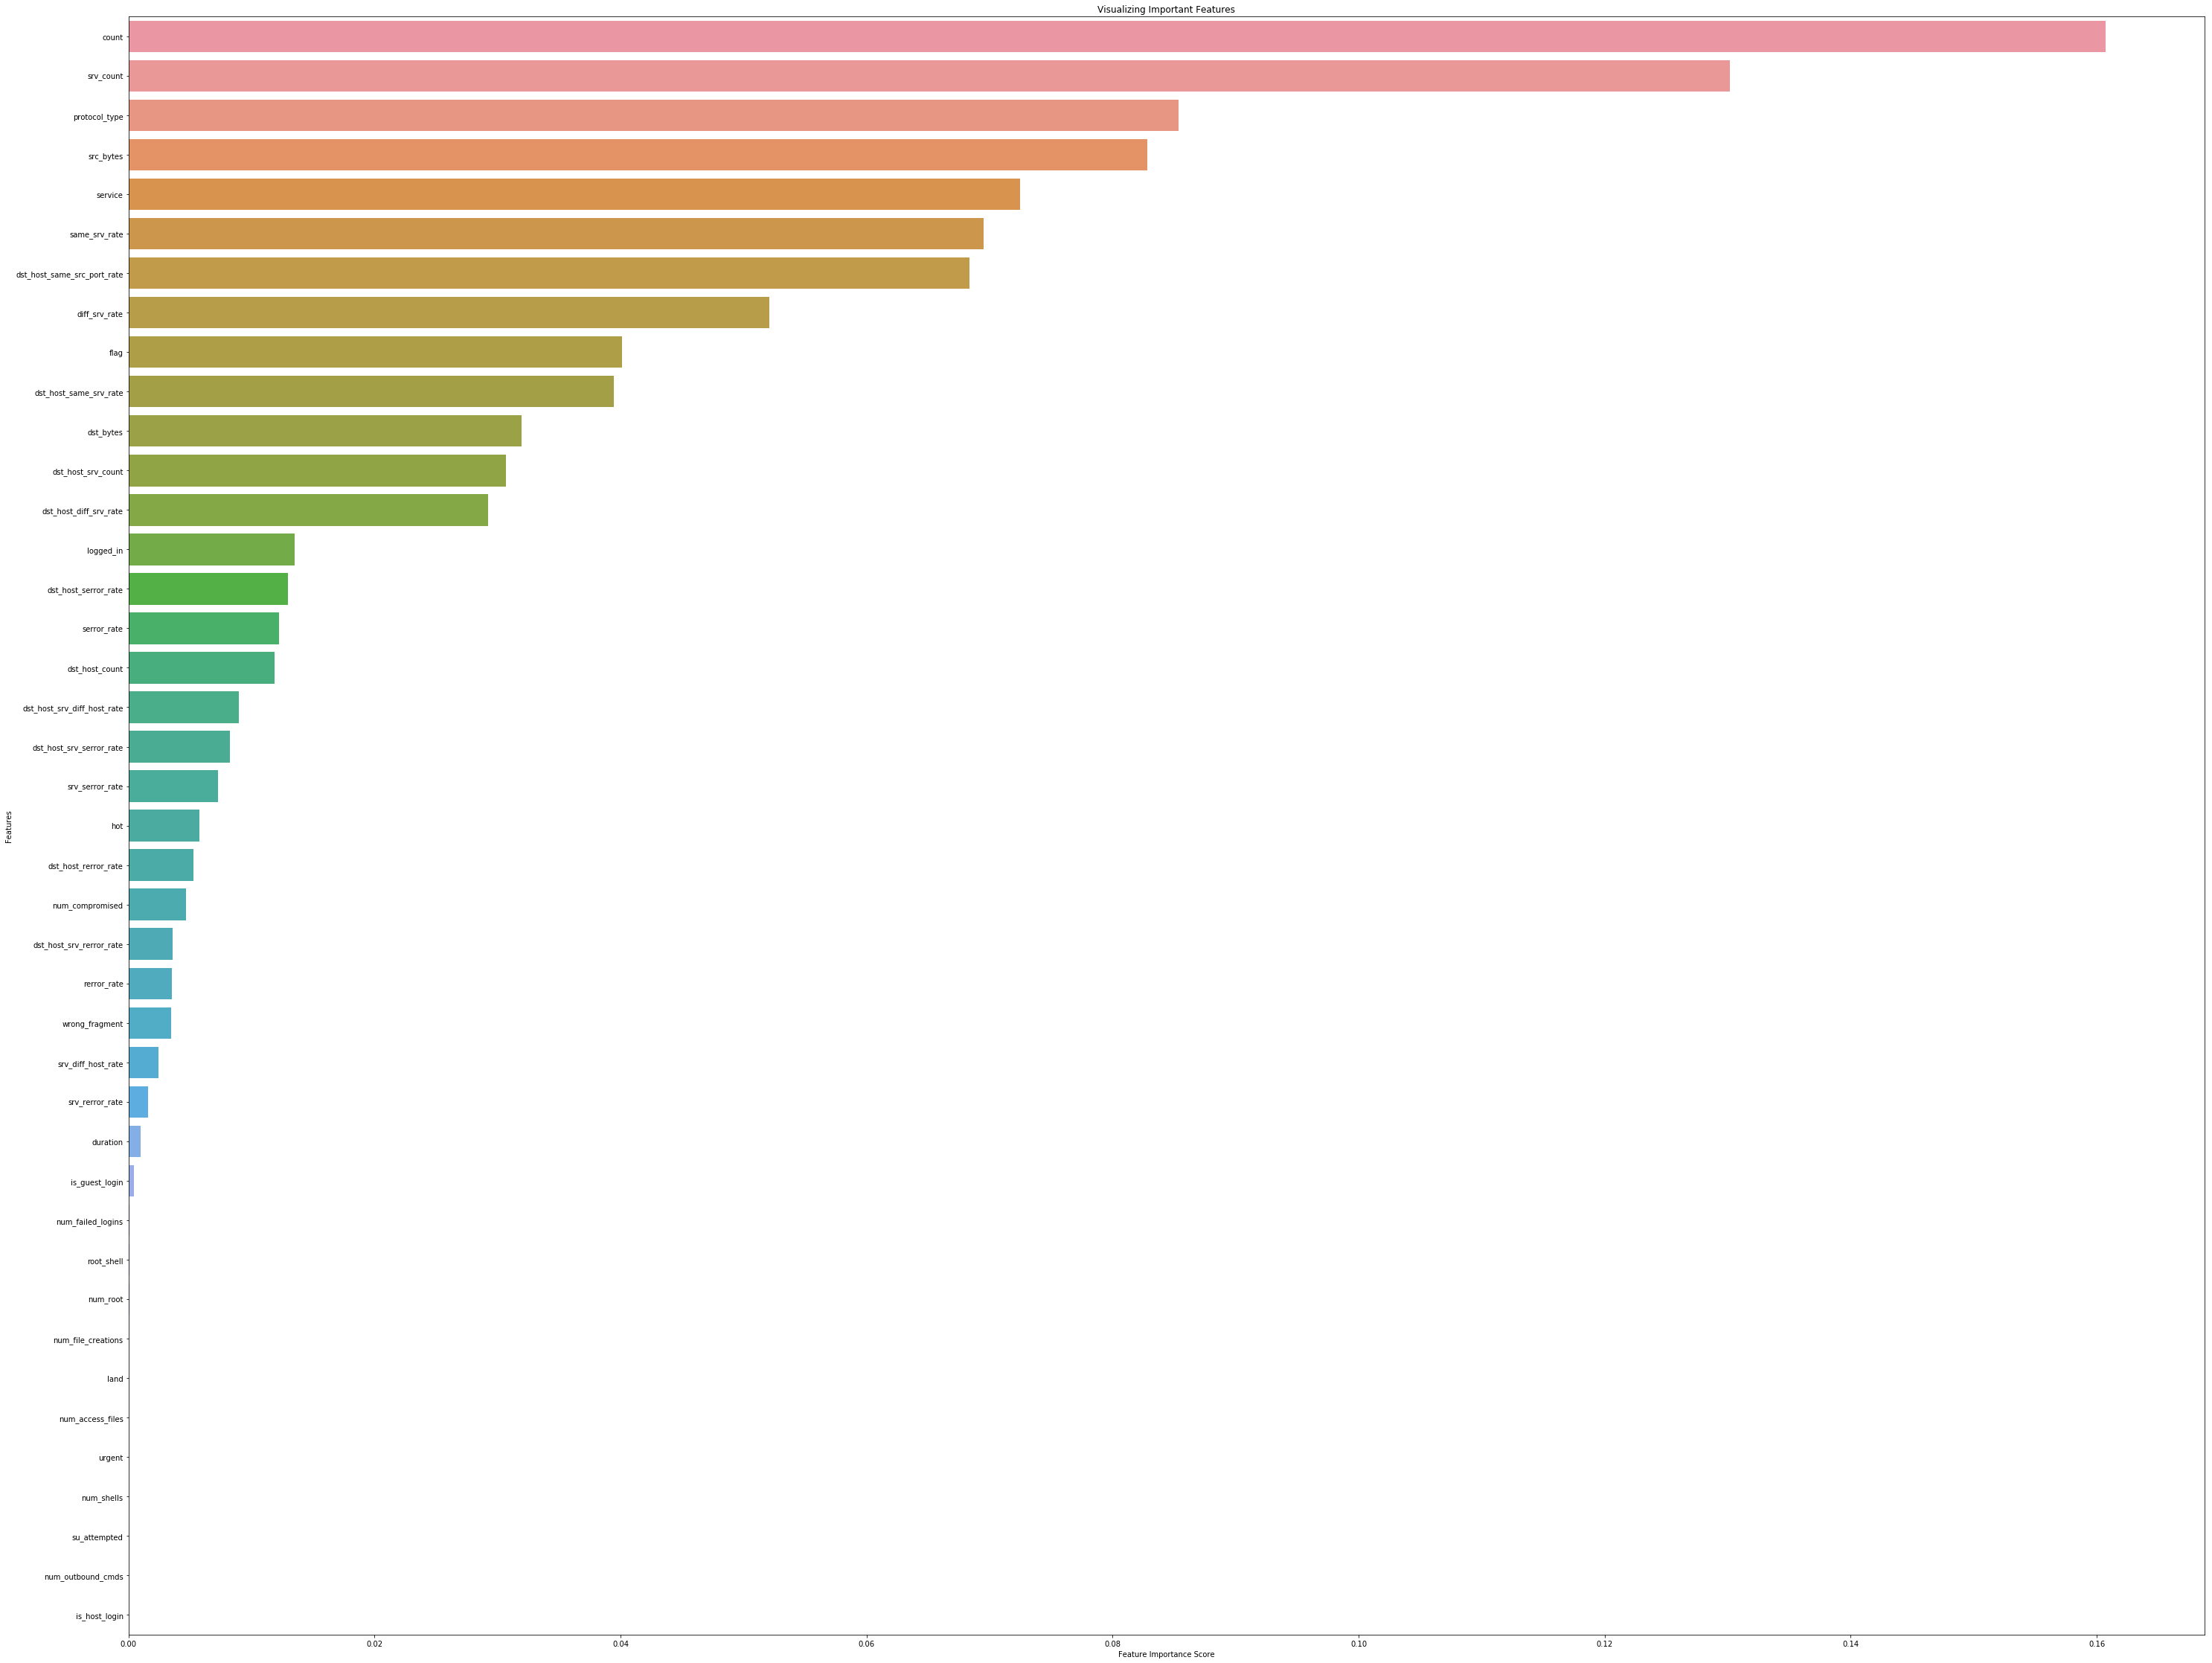

In [10]:
features_labels = list(X.columns.values) 
clf = RandomForestClassifier(n_estimators = 500, max_features = 'sqrt', criterion = 'entropy', n_jobs = 2)
clf.fit(X_train, y_train)
predicted = clf.predict(X_test) 
feature_imp = pd.Series(clf.feature_importances_,index=features_labels).sort_values(ascending=False)
plt.figure(figsize=(50,40))
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
sns.barplot(x=feature_imp, y=feature_imp.index)

In [11]:
a = feature_imp[feature_imp > 0.03]
X_train = X_train[a.index]
X_test = X_test[a.index]

In [12]:
a.shape

(12,)

In [13]:
a.index

Index(['count', 'srv_count', 'protocol_type', 'src_bytes', 'service',
       'same_srv_rate', 'dst_host_same_src_port_rate', 'diff_srv_rate', 'flag',
       'dst_host_same_srv_rate', 'dst_bytes', 'dst_host_srv_count'],
      dtype='object')

In [14]:
inputSize = a.shape[0]
inputSize

12

In [16]:
batch_size = 128
num_classes = 23
epochs = 11
#91
# the data, split between train and test sets
#(x_train, y_train), (x_test, y_test) = trainData


es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)


model = Sequential()
model.add(Dense(512, activation='tanh', input_shape=(inputSize,)))
model.add(Dropout(0.2))

model.add(Dense(num_classes, activation='softmax'))

model.summary()

#keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=0.9, nesterov=False)

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_test, y_test),callbacks=[es])
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 512)               6656      
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 23)                11799     
Total params: 18,455
Trainable params: 18,455
Non-trainable params: 0
_________________________________________________________________
Train on 345814 samples, validate on 148207 samples
Epoch 1/11


InternalError: cudaGetDevice() failed. Status: CUDA driver version is insufficient for CUDA runtime version

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


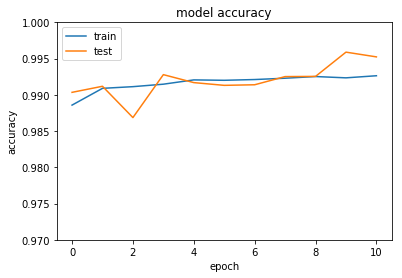

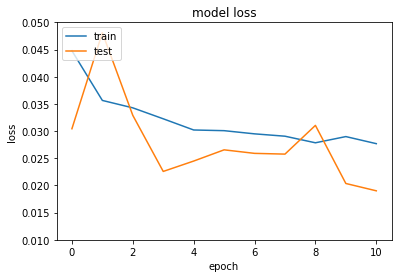

In [57]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim(0.97, 1)
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.ylim(0.01, 0.05)

plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [44]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

In [45]:
from sklearn.model_selection import KFold
import sklearn as sk

In [46]:
kf = KFold(n_splits=2)
Y_Pred = [0]*len(y_pred_test)

In [47]:
j = 0
for i in y_pred_test:
    Y_Pred[j] = np.where(  i == np.amax(i) )[0][0]
    j+=1

In [48]:
Y_Test = [0]*len(y_test)

In [49]:
j = 0
for i in y_test.get_values():
    Y_Test[j] = np.where(  i == 1)[0][0]
    j+=1

In [51]:
sk.metrics.f1_score(Y_Test , Y_Pred , average= 'weighted')

C:\Users\Ezgi\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.9949544269765509

In [52]:
sk.metrics.recall_score(Y_Test , Y_Pred , average= 'weighted')

0.9952363923431417

In [53]:
sk.metrics.precision_score(Y_Test , Y_Pred , average= 'weighted')

C:\Users\Ezgi\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.9953028523695665